<a href="https://colab.research.google.com/github/zachmakki15/ADVDS/blob/main/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zach Makki

Advanced Data Science

Project #4

02/20/2022

In [128]:
#Import the needed libs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

#Import training dataset
dataFrame_Train = pd.read_csv("https://raw.githubusercontent.com/zachmakki15/ADVDS/main/Train.csv")
#Import testing dataset
dataFrame_Test = pd.read_csv("https://raw.githubusercontent.com/zachmakki15/ADVDS/main/Test.csv")

#High-Level Data Visualization
First lets do a quick visual examination of the data in both the training and testing datasets, first lets combine the two datasets so that we can visualize the full dataset more easily

In [129]:
#View top 5 rows of training set
dataFrame_comb = pd.concat([dataFrame_Train, dataFrame_Test])
dataFrame_comb.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [130]:
#See details on the numeric values in the training set
dataFrame_comb.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


The counts for the columns in both are the dataset are not the same indicating there may be missing values in the dataset

Lets analyze the distrubution of the numeric values, excluding the ID column as this seems to be just an index

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88b91110d0>,
      dtype=object)

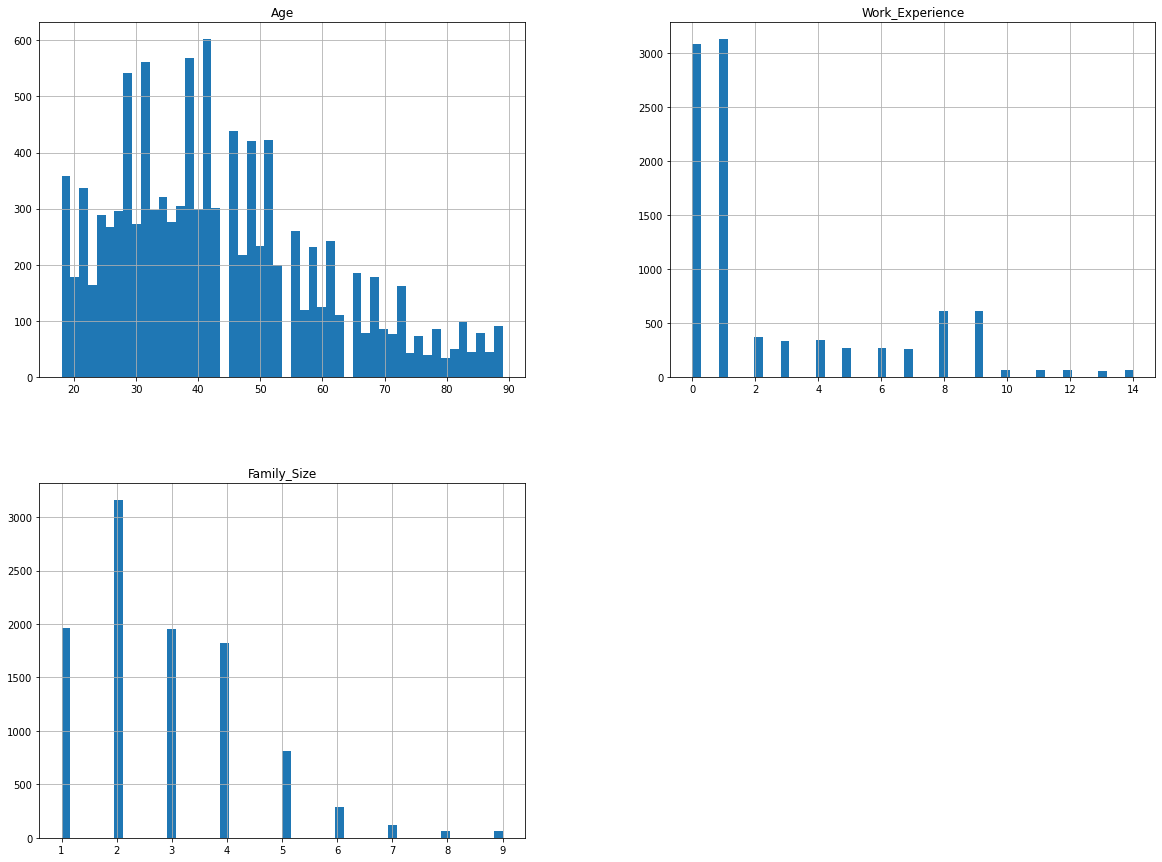

In [131]:
#Display historgrams for training data
dataFrame_comb.hist(bins=50, column=['Age', 'Work_Experience', 'Family_Size'], figsize=(20,15))

The distributions are not normally distributed and will need to be scaled.

Lets examine the distributions of the categoric attributes 

In [132]:
#Display value counts for the categoric attributes in the training data set
print(dataFrame_comb['Ever_Married'].value_counts())
print()
print(dataFrame_comb['Gender'].value_counts())
print()
print(dataFrame_comb['Graduated'].value_counts())
print()
print(dataFrame_comb['Profession'].value_counts())
print()
print(dataFrame_comb['Var_1'].value_counts())
print()
print(dataFrame_comb['Spending_Score'].value_counts())

Yes    6163
No     4342
Name: Ever_Married, dtype: int64

Male      5841
Female    4854
Name: Gender, dtype: int64

Yes    6570
No     4023
Name: Graduated, dtype: int64

Artist           3318
Healthcare       1750
Entertainment    1250
Engineer          935
Doctor            930
Lawyer            844
Executive         775
Marketing         403
Homemaker         328
Name: Profession, dtype: int64

Cat_6    6910
Cat_4    1475
Cat_3    1089
Cat_2     563
Cat_7     269
Cat_1     167
Cat_5     114
Name: Var_1, dtype: int64

Low        6494
Average    2599
High       1602
Name: Spending_Score, dtype: int64


Some takeaways from the results, there are way more artists in this dataset then other professions, as well as way more people with a low spending score, the other columns (with the exception of Var_1) seem to be more evenly distributed

In [133]:
print(dataFrame_comb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB
None


Multiple columns both numeric and categoric have missing values that need be to filled in both datasets

Before procceeding to the correlation check lets first drop the ID column from the table as this offers no information that can be of use to a model

In [134]:
#Drop ID column
dataFrame_comb = dataFrame_comb.drop(columns=['ID'])

#Correlation Check
Before scaling and filling missing values lets examine the pearsons r correlation between the attributes and the target class (Segmentation)

In [135]:
#Get correlation matrix from training data set
corr_matrix = dataFrame_comb.corr()
corr_matrix

,Age,Work_Experience,Family_Size
Age,1.000000,-0.189653,-0.281725
Work_Experience,-0.189653,1.000000,-0.065163
Family_Size,-0.281725,-0.065163,1.000000


Categoric colunms cannot be analyzed using pearsons r correlation so they will first have to be encoded before the correlation is ran. 

Due to this the data scaling and cleaning will be done before caluculating pearsons r correlation

Before calculating correlation lets seperate the target attribute from the rest of the dataset and encode it using the pandas encoding method. This is done because later when we break down the dataset into X, and Y we will have to use the normlization pipeline with it, and if the pipline thinks Y we be in the same dataset as X then the code will fail. 

In [136]:
#Build data cleaning and scaling pipeline
#First import libs
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

#Create x and y dataframes
y = dataFrame_comb[['Segmentation']]
x = dataFrame_comb.drop(columns=['Segmentation'])

#Seperate categoric and numeric columns
cats_cols = x.select_dtypes(include=['object']).columns
nums_cols = x.select_dtypes(include=['float', 'int']).columns

#Build categoric pipeline
cat_pipeline = Pipeline(steps=[
                               ('imputer', SimpleImputer(strategy='most_frequent')),
                               ('ordinal', OrdinalEncoder())
])

#Build numeric pipeline
num_pipeline = Pipeline(steps=[
                               ('imputer', SimpleImputer(strategy='mean')),
                               ('scalar', MinMaxScaler())
])

#Combine pipelines and transform data for both datasets
t = [('num', num_pipeline, nums_cols), ('cat', cat_pipeline, cats_cols)]
norm_pipeline = ColumnTransformer(transformers=t)

For some reason the column transformer is not working as I want it to. If I list the numeric pipeline first it treats the first four columns as numeric, if I list it after the cat pipeline it treats the last four columns as numeric. Due to this behavior I believe that I am either doing something wrong which I cannot identify or the column transformer only works if the columns are grouped together based on type. To work around this I will re-organize the columns so that numeric columns will be grouped first (1-4), then categoric columns last (5-11). 

In [137]:
#Re-arrange columns in training set based on type
x_cats = x.select_dtypes(include=['object'])
x_nums = x.select_dtypes(include=['float', 'int'])
x_grouped = pd.concat([x_nums, x_cats], axis=1)
x_grouped.head()

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,22,1.0,4.0,Male,No,No,Healthcare,Low,Cat_4
1,38,NaN,3.0,Female,Yes,Yes,Engineer,Average,Cat_4
2,67,1.0,1.0,Female,Yes,Yes,Engineer,Low,Cat_6
3,67,0.0,2.0,Male,Yes,Yes,Lawyer,High,Cat_6
4,40,NaN,6.0,Female,Yes,Yes,Entertainment,High,Cat_6


In [138]:
#Normalize training data using normalization pipeline
x_arr = norm_pipeline.fit_transform(x_grouped)
x_tr = pd.DataFrame(x_arr, columns=x_grouped.columns, index=x_grouped.index)
x_tr.head()

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,0.056338,0.071429,0.375,1.0,0.0,0.0,5.0,2.0,3.0
1,0.281690,0.187127,0.250,0.0,1.0,1.0,2.0,0.0,3.0
2,0.690141,0.071429,0.000,0.0,1.0,1.0,2.0,2.0,5.0
3,0.690141,0.000000,0.125,1.0,1.0,1.0,7.0,1.0,5.0
4,0.309859,0.187127,0.625,0.0,1.0,1.0,3.0,1.0,5.0


Now that the dataset has been transformed lets run the pearsons r correlation on it to see which attributes are most correlated to the target attribute segmentation

In [139]:
encoder =  OrdinalEncoder()
encoder.fit(y[['Segmentation']])
y[['Segmentation']] = encoder.transform(y[['Segmentation']])
y.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Segmentation
count,10695.000000
mean,1.530902
std,1.158536
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,3.000000


In [140]:
#Show correlation matrix for training data
#Add y back to x to compute correlation matrix
xy = pd.concat([x_tr,y], axis=1)
corr_matrix = xy.corr()
corr_matrix['Segmentation'].sort_values(ascending=False)

Segmentation       1.000000
Profession         0.169273
Family_Size        0.146514
Spending_Score     0.084906
Gender             0.018805
Work_Experience    0.005843
Var_1             -0.014580
Graduated         -0.145316
Ever_Married      -0.176650
Age               -0.200639
Name: Segmentation, dtype: float64

In [141]:
#Display heatmap
corr_matrix.style.background_gradient(cmap='coolwarm')

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
Age,1.000000,-0.178159,-0.274626,0.025208,0.559248,0.234660,0.048028,-0.273157,0.169914,-0.200639
Work_Experience,-0.178159,1.000000,-0.060590,-0.059278,-0.094208,0.035620,-0.020063,0.050973,0.020836,0.005843
Family_Size,-0.274626,-0.060590,1.000000,0.058405,-0.077115,-0.233029,0.086718,-0.109654,-0.152534,0.146514
Gender,0.025208,-0.059278,0.058405,1.000000,0.109510,-0.038717,0.027212,-0.051264,0.029402,0.018805
Ever_Married,0.559248,-0.094208,-0.077115,0.109510,1.000000,0.190520,-0.124329,-0.620511,0.075124,-0.176650
Graduated,0.234660,0.035620,-0.233029,-0.038717,0.190520,1.000000,-0.291061,-0.148761,0.125900,-0.145316
Profession,0.048028,-0.020063,0.086718,0.027212,-0.124329,-0.291061,1.000000,0.224664,-0.036831,0.169273
Spending_Score,-0.273157,0.050973,-0.109654,-0.051264,-0.620511,-0.148761,0.224664,1.000000,-0.028457,0.084906
Var_1,0.169914,0.020836,-0.152534,0.029402,0.075124,0.125900,-0.036831,-0.028457,1.000000,-0.014580
Segmentation,-0.200639,0.005843,0.146514,0.018805,-0.176650,-0.145316,0.169273,0.084906,-0.014580,1.000000


After that dataset has been normalized there is no one attribute which has a strong correlation to segmentation, but lets cross-tabulate the 3 attributes which have the highest (Profession, Gender, Spending Score) correlation with the target attribute (Segmentation) and make sense to view graphically (this is why we choose gender over family_size)

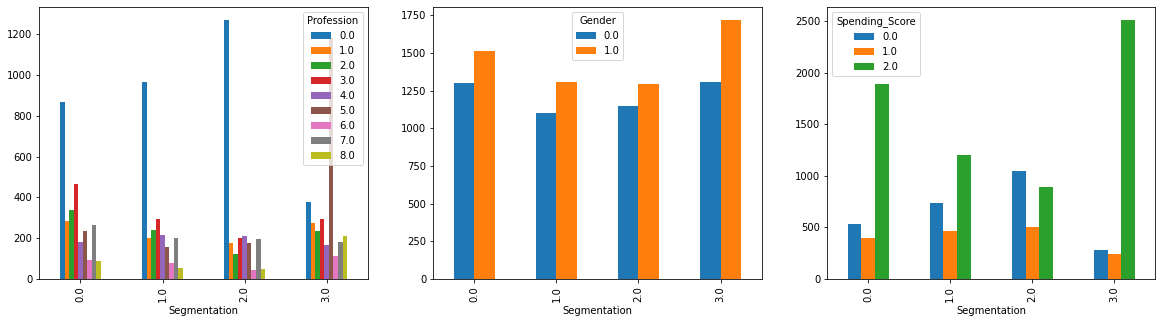

In [142]:
# distribution of profession by segmentation
figure, axes = plt.subplots(1, 3)
profession_BarGraph = pd.crosstab(xy['Segmentation'], xy['Profession'])
profession_BarGraph.plot.bar(ax = axes[0],figsize=(20,5))

#distribution of family size by segmentation
gender_BarGraph = pd.crosstab(xy['Segmentation'], xy['Gender'])
gender_BarGraph.plot.bar(ax = axes[1], figsize=(20,5))

#distribution of spending score by segmentation
spendingScore_BarGraph = pd.crosstab(xy['Segmentation'], xy['Spending_Score'])
spendingScore_BarGraph.plot.bar(ax = axes[2], figsize=(20,5))

From analyzing the charts above one thing sticks out, for spending score having a category of 2 (green bars) seems to highly correlate to being in segmenation 0 (A) or 3 (D), with a large majority of the rows segmented as D also having a spending score of 2. But this could also be due to the fact that there are more 2s in the dataset then 1s or 0s for spending score. It also appears as though there is some relationship being having a profession category of 0 and not being in segmentation D, but this could also be due to the high number of profession category 0s are in the dataset.

By using the normalization pipeline to transform the data to check the attributes correlation to the target we have visualized the data while also testing and confirming our normalization pipeline correctly transforms the data.

One thing we have seen from the correlation is the attribute Var_1 does not correlate with the target attribute at all (almost 0), since it also has no explanation for its significance so we will drop it from our dataset. Work experience is also close to 0 so we will drop this attribute from our dataset as well. 

In [143]:
dataFrame_comb = dataFrame_comb.drop(columns=['Work_Experience', 'Var_1'])

#Model Pipelines
Create pipelines for SVM and Decision Tree (DT) models using the normilization pipeline created in the correlation check section of this report.

The models will be tested using the cross fold validation method, this is why earlier in the code the datasets for training and testing were combined.

In [144]:
#Import the needed libs for model building
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

#Rebuild pipelines to handle dropped columns
#Create x and y dataframes
x = dataFrame_comb.drop(columns=['Segmentation'])

#Seperate categoric and numeric columns
cats_cols = x.select_dtypes(include=['object']).columns
nums_cols = x.select_dtypes(include=['float', 'int']).columns

#Combine pipelines
t = [('num', num_pipeline, nums_cols), ('cat', cat_pipeline, cats_cols)]
preproccess_pipeline = ColumnTransformer(transformers=t)

#Rearrange x so column transformer will work
x_cats = x.select_dtypes(include=['object'])
x_nums = x.select_dtypes(include=['float', 'int'])
x_grouped = pd.concat([x_nums, x_cats], axis=1)
numFolds = 5

x_grouped_svm = x_grouped[:2000]
y_svm = y[:2000]

rbf_SVC_Pipeline = Pipeline(steps=[
                                   ('normalize', preproccess_pipeline),
                                   ('model', OneVsRestClassifier(SVC(kernel='rbf', C=10)))
])
rbf_SVC_Pipeline_score = cross_val_score(rbf_SVC_Pipeline, x_grouped_svm, y_svm.values.ravel(), cv=numFolds, scoring="accuracy").mean()
print('RBF: ', rbf_SVC_Pipeline_score)

poly_SVC_Pipeline = Pipeline(steps=[
                                   ('normalize', preproccess_pipeline),
                                   ('model', OneVsRestClassifier(SVC(kernel='poly', degree=4, C=5)))
])
poly_SVC_Pipeline_score = cross_val_score(poly_SVC_Pipeline, x_grouped_svm, y_svm.values.ravel(), cv=numFolds, scoring="accuracy").mean()
print('Poly: ', poly_SVC_Pipeline_score)

linear_SVC_Pipeline = Pipeline(steps=[
                                   ('normalize', preproccess_pipeline),
                                   ('model', OneVsRestClassifier(SVC(kernel='linear', C=7)))
])
linear_SVC_Pipeline_score = cross_val_score(linear_SVC_Pipeline, x_grouped_svm, y_svm.values.ravel(), cv=numFolds, scoring="accuracy").mean()
print('Linear: ', linear_SVC_Pipeline_score)

dt_Gini_Pipeline = Pipeline(steps=[
                                   ('normalize', preproccess_pipeline),
                                   ('model', DecisionTreeClassifier(criterion='gini'))
])
dt_Gini_Pipeline_score = cross_val_score(dt_Gini_Pipeline, x_grouped, y.values.ravel(), cv=numFolds, scoring="accuracy").mean()
print('Decision Tree Gini: ', dt_Gini_Pipeline_score)

dt_Ent_Pipeline = Pipeline(steps=[
                                   ('normalize', preproccess_pipeline),
                                   ('model', DecisionTreeClassifier(criterion='entropy'))
])
dt_Ent_Pipeline_score = cross_val_score(dt_Ent_Pipeline, x_grouped, y.values.ravel(), cv=numFolds, scoring="accuracy").mean()
print('Decision Tree Gini: ', dt_Ent_Pipeline_score)

RBF:  0.5109999999999999
Poly:  0.4845
Linear:  0.4565
Decision Tree Gini:  0.3921458625525947
Decision Tree Gini:  0.39513791491351097


Some notes from the results above. When SVC was ran with the original dataset (all 10000+ rows) it took over two minutes for just one the SVC pipelines to complete. Due to this I reduced the size of the dataset for the SVC models to 2000 rows. This actually increased the cross val accuracy score from about 0.4 to 0.5 for the RBF SVC model. Changing the C and the Gamma hyperparameters sometimes led to runtimes over three minutes which had to be manually terminated, the parameters chosen were ones that did not cause run-times of over one minute.

Lets visualize the results for both the decision trees and the svc models.

|--- Age <= 0.23
|   |--- Age <= 0.08
|   |   |--- Profession <= 4.50
|   |   |   |--- truncated branch of depth 15
|   |   |--- Profession >  4.50
|   |   |   |--- truncated branch of depth 14
|   |--- Age >  0.08
|   |   |--- Profession <= 3.50
|   |   |   |--- truncated branch of depth 18
|   |   |--- Profession >  3.50
|   |   |   |--- truncated branch of depth 19
|--- Age >  0.23
|   |--- Spending_Score <= 1.50
|   |   |--- Graduated <= 0.50
|   |   |   |--- truncated branch of depth 23
|   |   |--- Graduated >  0.50
|   |   |   |--- truncated branch of depth 23
|   |--- Spending_Score >  1.50
|   |   |--- Profession <= 0.50
|   |   |   |--- truncated branch of depth 18
|   |   |--- Profession >  0.50
|   |   |   |--- truncated branch of depth 26



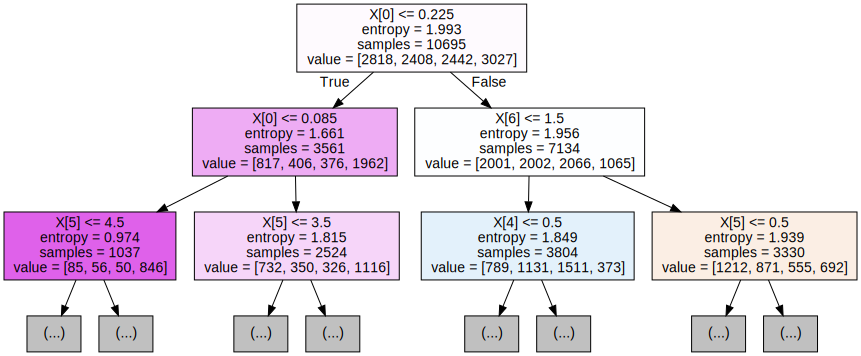

In [145]:
from sklearn.tree import export_text, export_graphviz
import graphviz

dt_Ent_Pipeline['model'].fit(preproccess_pipeline.fit_transform(x_grouped), y)
text_representation = export_text(dt_Ent_Pipeline['model'], feature_names=['Age', 'Family_Size', 'Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score'], max_depth=2)
print(text_representation)
dot_data = export_graphviz(dt_Ent_Pipeline['model'], max_depth=2, filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

|--- Age <= 0.23
|   |--- Age <= 0.08
|   |   |--- Profession <= 4.50
|   |   |   |--- truncated branch of depth 15
|   |   |--- Profession >  4.50
|   |   |   |--- truncated branch of depth 14
|   |--- Age >  0.08
|   |   |--- Profession <= 3.50
|   |   |   |--- truncated branch of depth 16
|   |   |--- Profession >  3.50
|   |   |   |--- truncated branch of depth 21
|--- Age >  0.23
|   |--- Spending_Score <= 1.50
|   |   |--- Profession <= 0.50
|   |   |   |--- truncated branch of depth 19
|   |   |--- Profession >  0.50
|   |   |   |--- truncated branch of depth 23
|   |--- Spending_Score >  1.50
|   |   |--- Profession <= 1.50
|   |   |   |--- truncated branch of depth 21
|   |   |--- Profession >  1.50
|   |   |   |--- truncated branch of depth 21



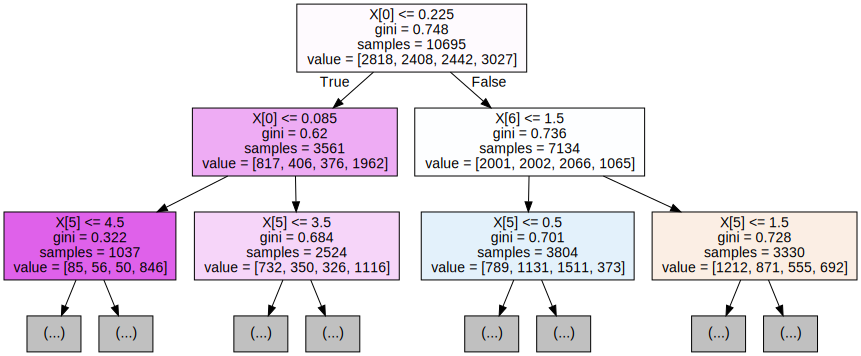

In [146]:
from sklearn.tree import export_text, export_graphviz
import graphviz

dt_Gini_Pipeline['model'].fit(preproccess_pipeline.fit_transform(x_grouped), y)
text_representation = export_text(dt_Gini_Pipeline['model'], feature_names=['Age', 'Family_Size', 'Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score'], max_depth=2)
print(text_representation)
dot_data = export_graphviz(dt_Gini_Pipeline['model'], max_depth=2, filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

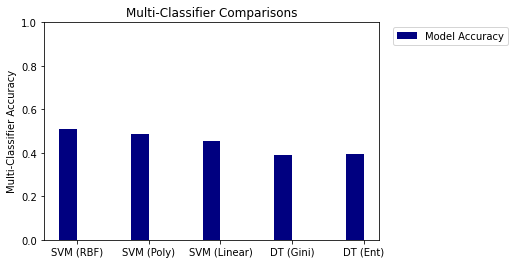

In [150]:
#Graph Data
labels = ['SVM (RBF)', 'SVM (Poly)', 'SVM (Linear)', 'DT (Gini)', 'DT (Ent)']
training_scores = [rbf_SVC_Pipeline_score, poly_SVC_Pipeline_score, linear_SVC_Pipeline_score, dt_Gini_Pipeline_score, dt_Ent_Pipeline_score]

x = np.arange(len(labels))
width = 0.25  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='Model Accuracy', color='navy')

ax.set_ylabel('Multi-Classifier Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.4, 1.0), loc='upper right')

plt.title('Multi-Classifier Comparisons')
plt.show()

The above results are not great, tests have been done using MinMax scalar instead of standard scalar, mean imputer instead of mode imputer, and no major difference is made on the model accuracy. Tests were also ran with the Var_1 attribute and Work_Experience attribute left in the dataset and the model accuracy was on average worse then it was in this test run. 

Due to the lack of promising results so far, a GridSearch will be performed on the models attempting to optimize the value for multiple mode hyper-parameters.

#Grid Search
Use grid search to try and optimize the hyper-parameters for both decision tree and SVM models.

In [153]:
#Decision Tree grid search
from sklearn.model_selection import GridSearchCV
dt_gridSearch_hyperParams = {'criterion':['gini', 'entropy'], 'max_depth':np.arange(5,25)}
dt_gridSearch = GridSearchCV(dt_Ent_Pipeline['model'], dt_gridSearch_hyperParams, cv=3)
dt_gridSearch.fit(preproccess_pipeline.fit_transform(x_grouped), y)
print("The best DT grid search accuracy: %.2f\n" % dt_gridSearch.best_score_)
print("The best DT hyperparameters:", dt_gridSearch.best_params_)

The best DT grid search accuracy: 0.47

The best DT hyperparameters: {'criterion': 'gini', 'max_depth': 5}


In [152]:
#SVM grid search
svm_gridSearch_hyperParams = {'kernel':['poly', 'rbf'], 'C':np.arange(1,10), 'gamma':['scale', 'auto']}
svm_gridSearch = GridSearchCV(SVC(), svm_gridSearch_hyperParams, cv=3)
svm_gridSearch.fit(preproccess_pipeline.fit_transform(x_grouped_svm), y_svm.values.ravel())
print("The best DT grid search accuracy: %.2f\n" % svm_gridSearch.best_score_)
print("The best DT hyperparameters:", svm_gridSearch.best_params_)

The best DT grid search accuracy: 0.53

The best DT hyperparameters: {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}


Lets visualize the results of the grid search compared to the results of the non-grid search optimized models of the same type. 

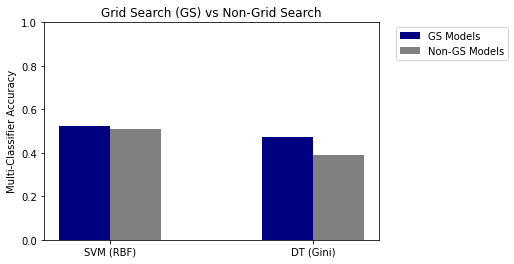

In [154]:
#Graph Data
labels = ['SVM (RBF)', 'DT (Gini)']
scores = [svm_gridSearch.best_score_, dt_gridSearch.best_score_]
ngs_scores = [rbf_SVC_Pipeline_score, dt_Gini_Pipeline_score]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scores, width, label='GS Models', color='navy')
rects1 = ax.bar(x + width/2, ngs_scores, width, label='Non-GS Models', color='grey')

ax.set_ylabel('Multi-Classifier Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.4, 1.0), loc='upper right')

plt.title('Grid Search (GS) vs Non-Grid Search')
plt.show()

#My Conclusions


From the results of both the non-grid search optimized models and the grid-search optimized models we can claim that in this test, this dataset did not perform well with SVM and Decision Tree models. I tested with different numeric scalars (standard, minmax), different impute strategys (mean, mode) and with different dropped attributes (seperate tests were ran dropping attribute Graduated then attribute Gender) and no significant difference was made to model accuracy. 

One way that I could have tested differently is by changing the method of encoding from ordinal to OneHotEncoder, I avoided testing this due to the number of columns it would have created, but perhpas that would of been better for the model. Log scale could also have been tested, as well as additional dropping of attributes from the dataset. These would be the tests I would run if I came back to this code looking for potential improvements in model accuracy.